
# ResNet-Competition

__Author:
Viktor Karlsson [viktor2karlsson@gmail.com](mailto:viktor2karlsson@gmail.com)__

In [45]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import add as keras_add
from keras.layers import Dense, Input, Activation, BatchNormalization
from keras.initializers import RandomNormal, Identity
from keras.regularizers import l1, l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# load (downloaded if needed) the MNIST dataset
(X_train_all, Y_train_all), (X_test, Y_test) = mnist.load_data()

## Data splitting and preprocessing

In [46]:
print(f'Shape of X_train is: {X_train_all.shape}')
print(f'Shape of Y_train is: {Y_train_all.shape}\n')

print('Reshaping training data into vector...')
X_train_all = X_train_all.reshape(X_train_all.shape[0], np.prod(X_train_all.shape[1:]))
print(f'Shape of X_train is now: {X_train_all.shape}\n')

print('Transforming training labels into one-hot encodings...')
Y_train_all = to_categorical(Y_train_all)
print(f'Shape of Y_train is now: {Y_train_all.shape}\n')

X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, Y_train_all, test_size=5000)
print(f'Using {len(X_train)} for training and {len(X_val)} for validation.')
print(f'Using {len(X_test)} for testing')

print('Reshaping testing data into vector...')
X_test = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))
print(f'Shape of X_test is now: {X_test.shape}\n')

print('Transforming testing labels into one-hot encodings...')
Y_test = to_categorical(Y_test)
print(f'Shape of Y_test is now: {Y_test.shape}\n')



Shape of X_train is: (60000, 28, 28)
Shape of Y_train is: (60000,)

Reshaping training data into vector...
Shape of X_train is now: (60000, 784)

Transforming training labels into one-hot encodings...
Shape of Y_train is now: (60000, 10)

Using 55000 for training and 5000 for validation.
Using 10000 for testing
Reshaping testing data into vector...
Shape of X_test is now: (10000, 784)

Transforming testing labels into one-hot encodings...
Shape of Y_test is now: (10000, 10)



# MLP
Defining functions that will be used for training MLP's

In [ ]:
def custom_dense_mlp(dim, is_input_layer=False, input_dim=784, activation='relu', seed=1337):
    
    '''Function for creating a common layers in the MLP used in this notetbook'''
    
    if is_input_layer:    
        return Dense(dim, 
                     input_dim=input_dim,
                     activation=activation, 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=seed), 
                     bias_initializer='zeros', 
                    )
    else:
        return Dense(dim,  
                     activation=activation, 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=seed), 
                     bias_initializer='zeros', 
                    )      
#end def

def create_mlp(dims, add_BN_layers=False, BN_gap=1, activation='relu', input_dim=784, output_dim=10):
    
    '''
    Function for stacking together multiple custom_dense_mlp into a list 
    which are put into a Sequential model
    '''
    
    layers = list()
    
    #input layer
    layers.append(custom_dense_mlp(dims[0], is_input_layer=True))
    #layers.append(BatchNormalization())


    dims = dims[1:]
    
    #hidden layers
    for i, dim in enumerate(dims):
        layers.append(custom_dense_mlp(dim))
    #end for
    
    #output layer
    layers.append(custom_dense_mlp(output_dim, activation='softmax'))
    
    model = Sequential(layers)

    return model
#end def

def train_mlp(model, epochs=10, lr=0.01, decay=0, momentum=0.9, patience=5):
    
    ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    
    optimizer = optimizers.SGD(lr=lr, decay=decay, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    model.summary()
    history = model.fit(X_train, Y_train, epochs=epochs, callbacks=[ES], batch_size=256, validation_data=(X_val, Y_val), verbose=0)

    return history

def history_plot(history):
    
    '''
    Function for plotting validation and training accuracy and loss. 
    '''
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    val_acc = history.model.evaluate(X_val, Y_val)[1]
    plt.title('model accuracy - {}'.format(round(val_acc, 5)))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return
#end def 


## Training MLP's
To create a good environment for testing the power of the ResNet architecture I will create two different model architectures for which I can compare the results

### Shallow MLP
This first model is a MLP with 5 layers, using almost all of the avaliable 10.000 paramters.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                9420      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_4 (Dense)              (None, 11)                143       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                120       
Total params: 9,995
Trainable params: 9,995
Non-trainable params: 0
_________________________________________________________________
5000/5000 [==============================] - 0s 20us/step


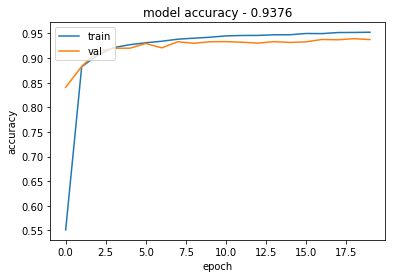

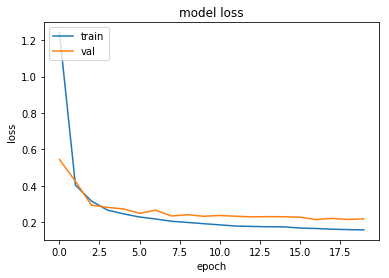

In [4]:
dims = [12,12,12,11]

shallow_model = create_mlp(dims)
shallow_history = train_mlp(shallow_model, epochs=20, lr=0.01, decay=0.001, patience=100)
history_plot(shallow_history)

We find that this network performs really good.

### Deep MLP
Since the purpose of ResNet is to enable efficient learning of deep models I see it appropriate to create a "very" deep MLP. Here a 11 layer model is created and tested.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 11)                8635      
_________________________________________________________________
dense_7 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_8 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_9 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_10 (Dense)             (None, 11)                132       
_________________________________________________________________
dense_11 (Dense)             (None, 11)                132       
_________________________________________________________________
dense_12 (Dense)             (None, 11)                132       
__________

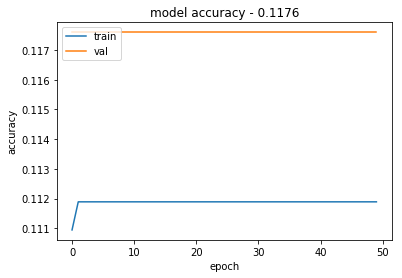

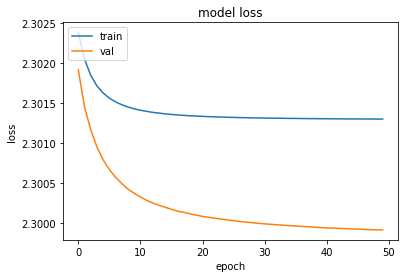

In [5]:
dims = [11]*7+[10]*4
deep_model = create_mlp(dims)

deep_history = train_mlp(deep_model, lr=0.001, decay=0.001, epochs=50, patience=5)
history_plot(deep_history)

# ResNet
We now turn to ResNets. This network focuses on learning the residuals in each step through letting the input to a layer bypass the activation. The number of layers that is bypassed can vary, as long as the dimension of input and output for this stack of layers are equivalent. If that is not the case, a dimensionality reduction of the saved state can be performer. I could not figure out how to implement that.

__Questions:__
 - How do you chose the matrix to mulitpky the shortcut with?
 - How do you implement this in Keras?
 

In [39]:
def custom_dense_resnet(output_dim, x, activation='relu',trainable=True):
    '''Creates a keras dense layer for use in my ResNet architecture'''
    return Dense(output_dim,
                 activation=activation,
                 kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1337),
                 trainable = trainable
                 )(x)
#end def

def resnet_block(dim, x, activation='relu'):
    # Can only handle shortcuts between layers of the same shape. 
    
    shortcut = x
    x = custom_dense_resnet(dim, x)
    x = custom_dense_resnet(dim, x, activation=None)        
    x = keras_add([shortcut, x])
    x = Activation(activation)(x)
    return x
#end def

def build_shallow_resnet():
    inp = Input(shape=(784,))
    x = custom_dense_resnet(12, inp)
    x = resnet_block(12, x)
    x = custom_dense_resnet(11, x)
    x = custom_dense_resnet(10, x, activation='softmax')

    model = Model(input=[inp], output=x)
    return model
#end def

def build_deep_resnet():
    inp = Input(shape=(784,))
    x = custom_dense_resnet(11, inp)
    x = resnet_block(11, x)
    x = resnet_block(11, x)
    x = resnet_block(11, x)
    x = custom_dense_resnet(10,x)
    x = resnet_block(10, x)
    x = custom_dense_resnet(10,x)
    x = custom_dense_resnet(10,x, activation='softmax')

    model = Model(input=[inp], output=x)
    return model
#end def

def build_deep_resnet_modified():
    inp = Input(shape=(784,))
    x = custom_dense_resnet(11, inp)
    x = resnet_block(11, x)
    x = resnet_block(11, x)
    x = resnet_block(11, x)
    x = custom_dense_resnet(10,x)
    x = custom_dense_resnet(10,x)
    x = custom_dense_resnet(10,x)
    x = custom_dense_resnet(10,x)
    x = custom_dense_resnet(10,x, activation='softmax')

    model = Model(input=[inp], output=x)
    return model
#end def



def build_super_deep_resnet():
    inp = Input(shape=(784,))
    x = Dense(444, activation=None, kernel_initializer=RandomNormal(mean=0.0, stddev=1, seed=1337), use_bias=False, trainable = False)(inp)
    x = custom_dense_resnet(16, x)
    x = resnet_block(16, x)
    x = resnet_block(16, x)
    
    x = custom_dense_resnet(14, x)
    x = resnet_block(14, x)
    x = resnet_block(14, x)
    
    x = custom_dense_resnet(10, x)
    x = resnet_block(10, x)
    x = custom_dense_resnet(10, x)
    x = custom_dense_resnet(10, x)
    
    x = custom_dense_resnet(10, x, activation='softmax')

    model = Model(input=[inp], output=x)
    return model
#end def


/Users/Viktor/miniconda3/envs/ResNet-Competition/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_76 (Dense)                (None, 12)           9420        input_6[0][0]                    
__________________________________________________________________________________________________
dense_77 (Dense)                (None, 12)           156         dense_76[0][0]                   
__________________________________________________________________________________________________
dense_78 (Dense)                (None, 12)           156         dense_77[0][0]                   
__________________________________________________________________________________________________
add_24 (Ad

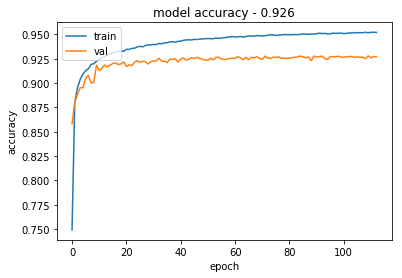

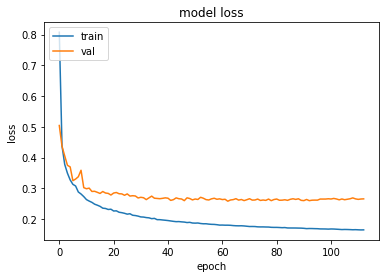

In [16]:
shallow_resnet_model = build_shallow_resnet()
shallow_resnet_history = train_mlp(shallow_resnet_model, lr=0.01, decay=0.001, epochs=1000, patience=50)
history_plot(shallow_resnet_history)

/Users/Viktor/miniconda3/envs/ResNet-Competition/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 11)           8635        input_7[0][0]                    
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 11)           132         dense_81[0][0]                   
__________________________________________________________________________________________________
dense_83 (Dense)                (None, 11)           132         dense_82[0][0]                   
__________________________________________________________________________________________________
add_25 (Ad

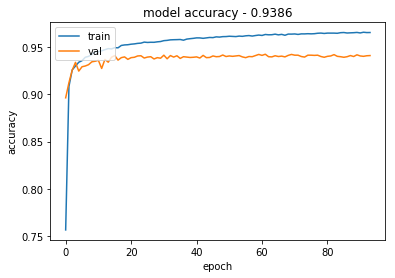

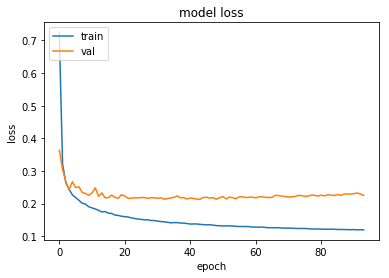

In [17]:
deep_resnet_model = build_deep_resnet()
deep_resnet_history = train_mlp(deep_resnet_model, lr=0.01, decay=0.001, epochs=1000, patience=50)
history_plot(deep_resnet_history)

I found that if i feed the shourtcut summary directly to a softmax activation, the performance is really poor. I wonder if this is because it it too big of a jump from representing the residuals to performing classification. It might be worth trying what happens if we allow for more fully connected layers at the end.

/Users/Viktor/miniconda3/envs/ResNet-Competition/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_101 (Dense)               (None, 11)           8635        input_9[0][0]                    
__________________________________________________________________________________________________
dense_102 (Dense)               (None, 11)           132         dense_101[0][0]                  
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 11)           132         dense_102[0][0]                  
__________________________________________________________________________________________________
add_32 (Ad

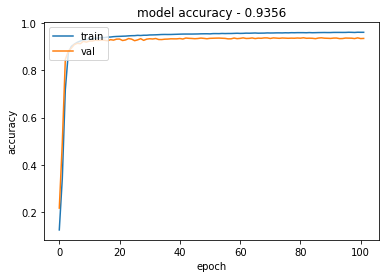

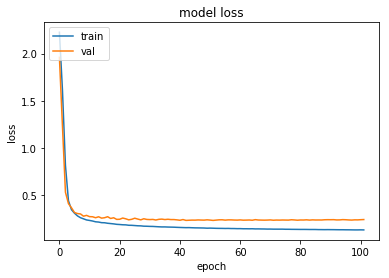

In [21]:
model = build_deep_resnet_modified()
history = train_mlp(model, lr=0.01, decay=0.001, epochs=1000, patience=50)
history_plot(history)

The performance did not change much. However, the convergence is a lot smoother. 

Finnaly I created a super deep network which starts with a random, but constant, dimensionality reduction to enable for more layers on the limitied budget of parameters. 

/Users/Viktor/miniconda3/envs/ResNet-Competition/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_278 (Dense)               (None, 444)          348096      input_21[0][0]                   
__________________________________________________________________________________________________
dense_279 (Dense)               (None, 16)           7120        dense_278[0][0]                  
__________________________________________________________________________________________________
dense_280 (Dense)               (None, 16)           272         dense_279[0][0]                  
__________________________________________________________________________________________________
dense_281 

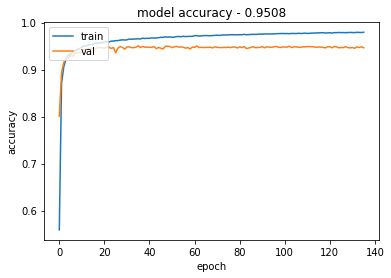

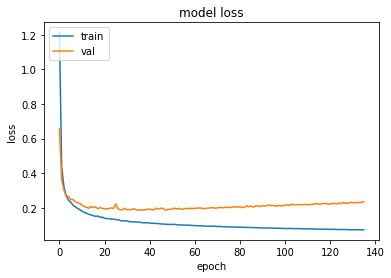

In [41]:
model = build_super_deep_resnet()
history = train_mlp(model, lr=0.005, decay=0.0005, epochs=1000, patience=100)
history_plot(history)

This super deep model is the one with best performance.

In [50]:
performance = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {performance[1]}')

10000/10000 [==============================] - 1s 52us/step
Test accuracy: 0.9526
